# Evaluation of hash functions

I’m not deeply familiar with the performance characteristics of different hash functions, so this notebook compares the collision frequency and execution time of several standard options. Uniform distribution of hash functions was omitted at this stage.

Based on the runtime advantage of Python’s built-in `hash()`, I will use it for Exercise 1.

Collision performance for all tested functions, aside from a few minor outliers, are visually similar.

The evaluatation was conducted as follows:
- Downloaded Gutenberg corpus (approx 33'000 unique words similar to the target text).
- Computed collision frequency of different hash functions for different hash table capacities based on the target corpus size of 9944.
  - Collision frequencies were bootstrapped using 50 random samples from the gutenberg corpus (size 10000).
  - Candidate hash table capacities were prime and powers of 2 (loading factors in [0.3, 0.7]).

In [95]:
import time
import random

import re
import time
import zlib

import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('gutenberg')


[nltk_data] Downloading package gutenberg to /home/lpupp/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [ ]:
# Import Gutenberg corpus and extract unique words
words = []
for id in nltk.corpus.gutenberg.fileids():
    corpus = nltk.corpus.gutenberg.words(id)
    words.extend([w.lower() for w in corpus if re.match(r"^[a-z]+$", w)])
    words = list(set(words))

print(words[:10])
print(len(words))

['suckingly', 'dangle', 'importune', 'detain', 'weariness', 'appertained', 'unprofitableness', 'bumper', 'splitting', 'attentive']
33346


In [ ]:
# Hash functions to test
MASK64 = (1 << 64) - 1
MOD_61 = (1 << 61) - 1

def builtin_hash(s):
    return hash(s)

def djb2_64(s):
    h = 5381
    for ch in s:
        h = ((h << 5) + h) + ord(ch)
        h &= MASK64
    return h

def sdbm_64(s):
    h = 0
    for ch in s:
        h = ord(ch) + (h << 6) + (h << 16) - h
        h &= MASK64
    return h

def fnv1a_64(s):
    h = 0xCBF29CE484222325
    for ch in s:
        h ^= ord(ch)
        h = (h * 0x100000001B3) & MASK64
    return h

def crc32_hash(s):
    return zlib.crc32(s.encode()) & 0xFFFFFFFF

def poly_mod_prime(s, base=131, mod=1_000_000_007):
    h = 0
    for ch in s:
        h = (h * base + ord(ch)) % mod
    return h

def poly_mod_2_61_1(s, base=911382323):
    h = 0
    for ch in s:
        h = (h * base + ord(ch)) % MOD_61
    return h

def make_poly_mod_table(base, table_size):
    def _h(s, _base=base, _mod=table_size):
        h = 0
        p = 1
        for ch in s:
            h = (h + (ord(ch) * p)) % _mod
            p = (p * _base) % _mod
        return h
    return _h

hash_funcs_by_name = {
    "builtin_hash": builtin_hash,
    "djb2_64": djb2_64,
    "sdbm_64": sdbm_64,
    "fnv1a_64": fnv1a_64,
    "crc32_32": crc32_hash,
    "poly_mod_prime_131": lambda s: poly_mod_prime(s, base=131, mod=1_000_000_007),
    "poly_mod_2^61-1": poly_mod_2_61_1,
}


In [ ]:
def collisions_for_hash_from_vals(vals, capacity):
    slots = [v % capacity for v in vals]
    return len(slots) - len(set(slots))

def compute_collisions(sample, r, capacities, hash_funcs_by_name, poly_table_bases):
    """
    Measures both collisions and hashing speed.
    For each hash function:
      - time a single pass computing hashes for all words in `sample`
      - reuse those hashes across all capacities to compute collisions
    Returns a list of dicts with fields:
      replicate, capacity, hash, collisions, hash_time_sec, hashes_per_sec, ns_per_hash
    """
    out = []

    # capacity-independent hashes
    for name, hf in hash_funcs_by_name.items():
        t0 = time.perf_counter()
        vals = [hf(w) for w in sample]
        hash_time = time.perf_counter() - t0
        hashes_per_sec = (len(sample) / hash_time) if hash_time > 0 else float("inf")
        ns_per_hash = (hash_time / len(sample)) * 1e9 if len(sample) else float("nan")

        for cap in capacities:
            col = collisions_for_hash_from_vals(vals, cap)
            out.append({
                "replicate": r,
                "capacity": cap,
                "hash": name,
                "collisions": col,
                "hash_time_sec": hash_time,
                "hashes_per_sec": hashes_per_sec,
                "ns_per_hash": ns_per_hash,
            })

    for base in poly_table_bases:
        for cap in capacities:
            hf = make_poly_mod_table(base, cap)
            name = f"poly_mod_table_base{base}"
            t0 = time.perf_counter()
            vals = [hf(w) for w in sample]  # already reduced mod cap inside hf
            hash_time = time.perf_counter() - t0
            hashes_per_sec = (len(sample) / hash_time) if hash_time > 0 else float("inf")
            ns_per_hash = (hash_time / len(sample)) * 1e9 if len(sample) else float("nan")
            # collisions: hashes are already in [0, cap), so modulo is a no-op; included for clarity.
            col = collisions_for_hash_from_vals(vals, cap)
            out.append({
                "replicate": r,
                "capacity": cap,
                "hash": name,
                "collisions": col,
                "hash_time_sec": hash_time,
                "hashes_per_sec": hashes_per_sec,
                "ns_per_hash": ns_per_hash,
            })

    return out

def bootstrap_collisions(corpus_unique, target_unique, capacities, hash_funcs_by_name, poly_table_bases, reps, seed):
    rng = random.Random(seed)
    out = []
    for r in range(reps):
        sample = rng.sample(corpus_unique, target_unique)
        out.extend(compute_collisions(sample, r, capacities, hash_funcs_by_name, poly_table_bases))
    return out


In [104]:
target_unique = 10_000  # Approximate size of A Tale of Two Cities, by Charles Dickens
poly_table_bases = [31, 37, 53, 131, 257]
seed = 1
reps = 50

# Capacities re corpus: primes + power-of-two baseline
capacities = [14293, 16673, 20011, 32768]

records = bootstrap_collisions(words, target_unique, capacities, hash_funcs_by_name, poly_table_bases, reps, seed)

df = pd.DataFrame(records)
df

,replicate,capacity,hash,collisions,hash_time_sec,hashes_per_sec,ns_per_hash
0,0,14293,builtin_hash,2812,0.001111,9.001492e+06,111.0927
1,0,16673,builtin_hash,2486,0.001111,9.001492e+06,111.0927
2,0,20011,builtin_hash,2139,0.001111,9.001492e+06,111.0927
3,0,32768,builtin_hash,1395,0.001111,9.001492e+06,111.0927
4,0,14293,djb2_64,2865,0.006854,1.458919e+06,685.4391
...,...,...,...,...,...,...,...
2395,49,32768,poly_mod_table_base131,1408,0.004791,2.087160e+06,479.1199
2396,49,14293,poly_mod_table_base257,2821,0.004567,2.189839e+06,456.6545
2397,49,16673,poly_mod_table_base257,2503,0.004657,2.147372e+06,465.6854
2398,49,20011,poly_mod_table_base257,2127,0.004468,2.238338e+06,446.7600


In [105]:
summary = (
    df.groupby(["capacity", "hash"])
      .agg(
          reps=("collisions", "count"),
          mean_collisions=("collisions", "mean"),
          std_collisions=("collisions", "std"),
          median=("collisions", "median"),
          p10=("collisions", lambda x: x.quantile(0.10)),
          p90=("collisions", lambda x: x.quantile(0.90)),
          mean_hash_time_sec=("hash_time_sec", "mean"),
          std_hash_time_sec=("hash_time_sec", "std"),
          mean_hashes_per_sec=("hashes_per_sec", "mean"),
          mean_ns_per_hash=("ns_per_hash", "mean"),
      )
      .reset_index()
)

summary["collisions_per_1k_keys"] = (
    summary["mean_collisions"] / (target_unique / 1000.0)
)


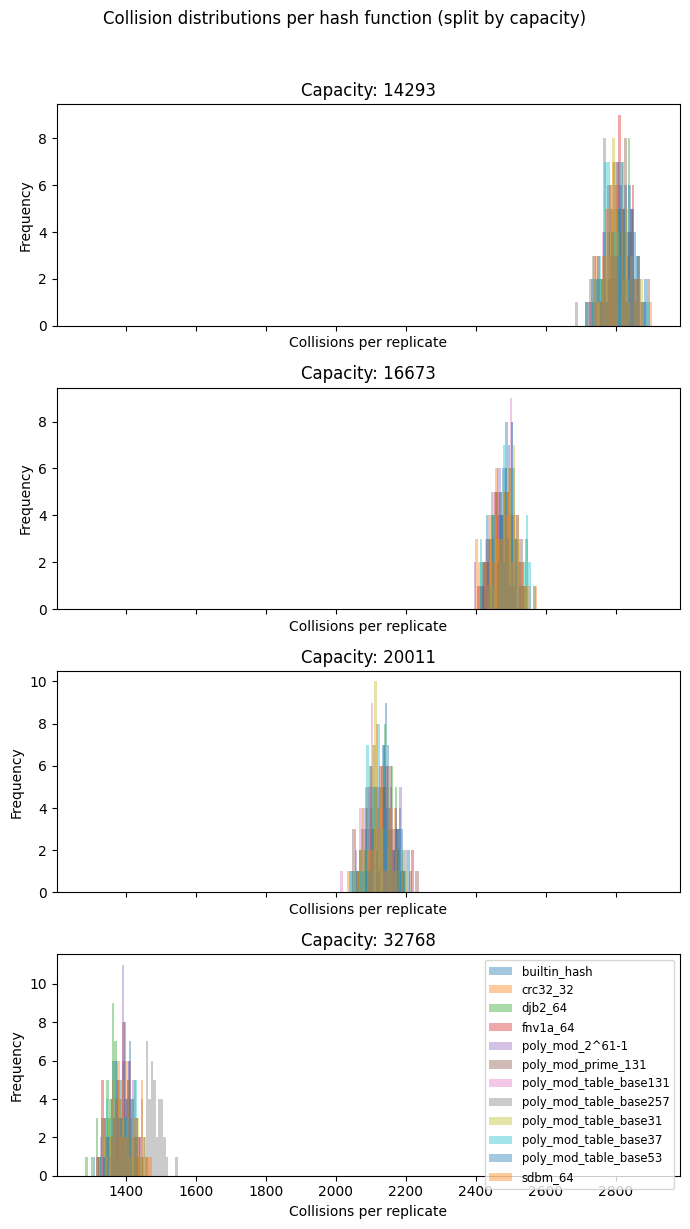

In [106]:
n_caps = len(capacities)

fig, axes = plt.subplots(n_caps, 1, figsize=(7, 3*n_caps), sharex=True)

for ax, cap in zip(axes, capacities):
    sub = df[df["capacity"] == cap]
    for hname, group in sub.groupby("hash"):
        ax.hist(
            group["collisions"],
            bins=20,
            alpha=0.4,
            label=hname
        )
    ax.set_title(f"Capacity: {cap}")
    ax.set_xlabel("Collisions per replicate")
    ax.set_ylabel("Frequency")
ax.legend(fontsize="small")

plt.suptitle("Collision distributions per hash function (split by capacity)", y=1.02)
plt.tight_layout()
plt.show()


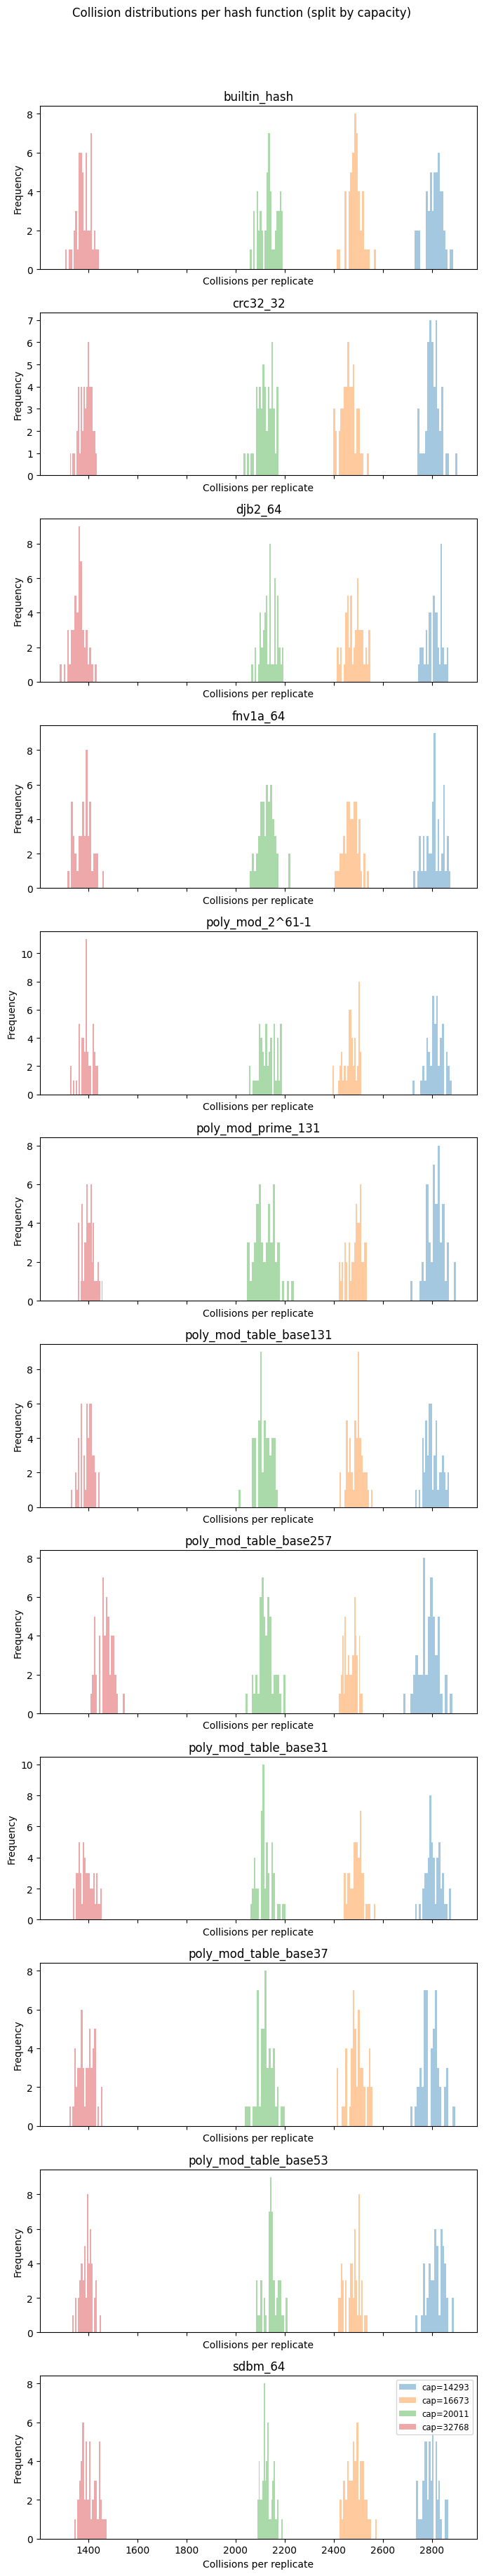

In [107]:
hashes = sorted(df["hash"].unique())
n_hashes = len(hashes)

fig, axes = plt.subplots(n_hashes, 1, figsize=(7, 3*n_hashes), sharex=True)

for ax, hname in zip(axes, hashes):
    sub = df[df["hash"] == hname]
    for cap, group in sub.groupby("capacity"):
        ax.hist(
            group["collisions"],
            bins=20,
            alpha=0.4,
            label=f"cap={cap}"
        )
    ax.set_title(hname)
    ax.set_xlabel("Collisions per replicate")
    ax.set_ylabel("Frequency")
ax.legend(fontsize="small")

plt.suptitle("Collision distributions per hash function (split by capacity)", y=1.02)
plt.tight_layout()
plt.show()


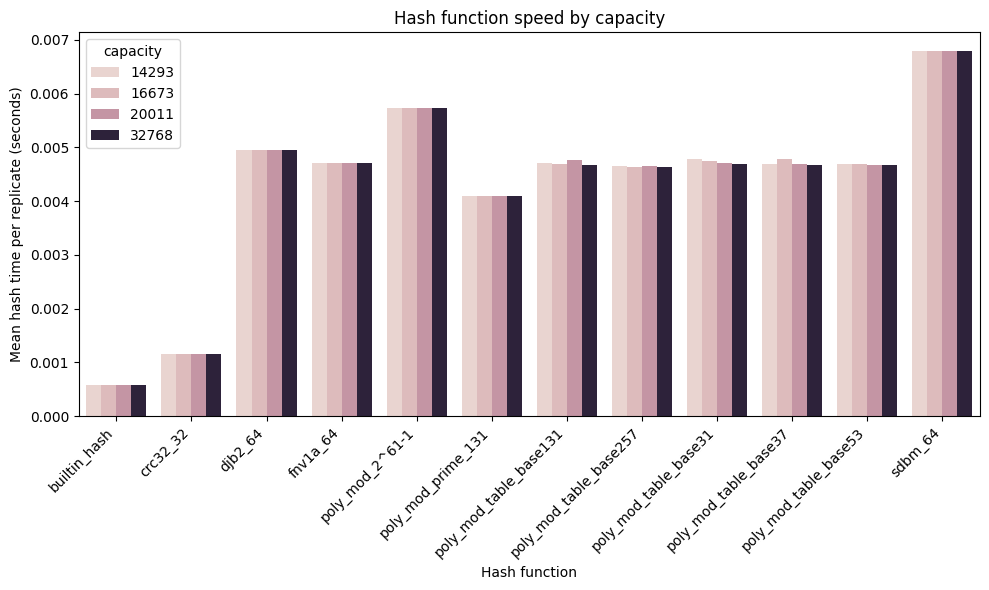

In [ ]:
import seaborn as sns

# Time doesn't depend on capacity, so the 4 bars per are redundant...

plt.figure(figsize=(10, 6))
sns.barplot(
    data=summary,
    x="hash",
    y="mean_hash_time_sec",
    hue="capacity"
)

plt.ylabel("Mean hash time per replicate (seconds)")
plt.xlabel("Hash function")
plt.title("Hash function speed by capacity")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()